In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
import string
sentence = list(string.ascii_lowercase)
sentence = 

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [3]:
# synthetic data

In [48]:
V = 11
nbatches = 5
batch = 5
b_X = []
b_y = []
block_size = 10
for i in range(nbatches):
    # tensor that does not require gradient!
    data = torch.from_numpy(np.random.randint(1,V, size=(batch, block_size)))
    # set all beginning of sentence as 1
    data[:, 0] = 1
    # code to copy input to output
    src = data
    tgt = data
#     # unsqeeze(-1) to get batch dimension
#     b_X.append(src.unsqueeze(0))
#     b_y.append(tgt.unsqueeze(0))
# X = torch.cat(b_X) ## dont need to do this because data is already batched
# y = torch.cat(b_y)

In [89]:
d_model = 16
vocab = nn.Embedding(V, 16)
src_emb = nn.Embedding(V, d_model)
tgt_emb = nn.Embedding(V, d_model)

# Self implementation

In [174]:
block_size= 100
d_model = 16
pos = torch.arange(0, block_size, 1).reshape(-1,1)
dim = torch.arange(0, d_model, 2).reshape(1, -1)
# pos_dim = pos * torch.exp( ((2 * dim) / d_model) * np.log(10000))
# pos_dim = pos * torch.exp( - ((2 * dim) / d_model) * math.log(10000)) ## dont need to multiply by 2 because dim is already 2i
pos_dim = pos * torch.exp( - ((dim) / d_model) * math.log(10000))


# even number 
positional_encoding = torch.zeros(block_size, d_model)
positional_encoding[:, torch.arange(0, d_model, 2)] = torch.sin(pos_dim)
positional_encoding[:, torch.arange(1, d_model, 2)] = torch.cos(pos_dim)
positional_encoding.shape

torch.Size([100, 16])

# Annotated transformer implementation

In [175]:
import math
pe = torch.zeros(block_size, d_model)
position = torch.arange(0, block_size).unsqueeze(1)
div_term = torch.exp(torch.arange(0,d_model,2) * - (math.log(10000) / d_model))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:,1::2] = torch.cos(position * div_term)
pe.shape

torch.Size([100, 16])

In [176]:
torch.equal(pe, positional_encoding)

True

# plot the positional encoding 

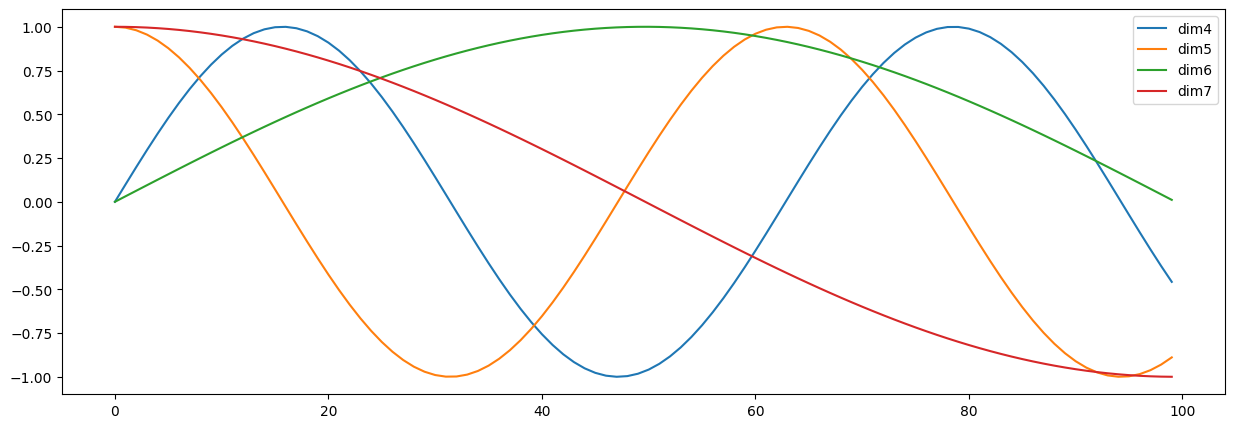

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(np.arange(100), positional_encoding[:,4:8].data.numpy())
plt.legend([f'dim{i}' for i in [4,5,6,7]])

# Show difference in plot due to numerical differences in the embedding layer
- when we change the d_model from 20 to 16, we get back the same pe plot as above

In [177]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.gg = pe
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + (self.pe[:, :x.size(1)])
        return self.dropout(x)

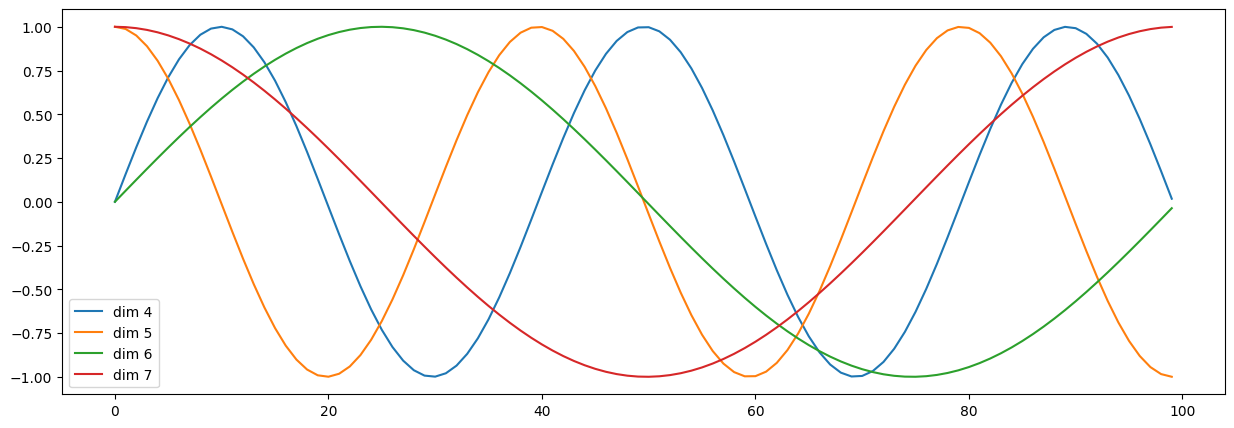

In [178]:
d_model = 20
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(d_model, 0)
y = pe.forward(torch.zeros(1, 100, d_model))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

#### We can see the plot looks different, but this is due to small numerical differences

In [185]:
#### redo own implementation with d_model from 16 to 20
block_size= 100
d_model = 20
pos = torch.arange(0, block_size, 1).reshape(-1,1)
dim = torch.arange(0, d_model, 2).reshape(1, -1)
pos_dim = pos * torch.exp( - ((dim) / d_model) * math.log(10000))

positional_encoding = torch.zeros(block_size, d_model)
positional_encoding[:, torch.arange(0, d_model, 2)] = torch.sin(pos_dim)
positional_encoding[:, torch.arange(1, d_model, 2)] = torch.cos(pos_dim)

### reinitialize annotated transformer implementation
pe = PositionalEncoding(d_model, 0, max_len=block_size)

In [186]:
torch.allclose(pe.gg, positional_encoding)

False

In [187]:
positional_encoding[(positional_encoding != pe.gg).squeeze()]

tensor([ 0.0631,  0.0040,  0.1259,  0.0080,  0.1882,  0.9821,  0.0119,  0.2497,
         0.0159,  0.3103,  0.9506,  0.0199,  0.3696,  0.0239,  0.4274,  0.0279,
         0.4836,  0.8753,  0.0318,  0.5378,  0.8431,  0.0358,  0.5899,  0.8075,
         0.0398,  0.6397,  0.7687,  0.0438,  0.6869,  0.7268,  0.0478,  0.7313,
         0.6820,  0.0517,  0.7729,  0.6346,  0.0557,  0.8113,  0.5846,  0.0597,
         0.8466,  0.5323,  0.0637,  0.8785,  0.4778,  0.0676,  0.9068,  0.4215,
         0.0716,  0.9974,  0.9316,  0.3635,  0.0756,  0.9527,  0.3040,  0.0795,
         0.9699,  0.2433,  0.0835,  0.9834,  0.1817,  0.0875,  0.1193,  0.0914,
         0.0565,  0.0954, -0.0066,  0.0994,  0.9976, -0.0696,  0.1033,  0.9912,
        -0.1324,  0.1073,  0.9809, -0.1946,  0.1112,  0.9667, -0.2561,  0.1152,
         0.9486, -0.3165,  0.1191,  0.9267, -0.3757,  0.1231,  0.9012, -0.4334,
         0.1270,  0.8721, -0.4894,  0.1310,  0.8395, -0.5434,  0.1349,  0.8036,
        -0.5952,  0.1389,  0.7644, -0.64

In [188]:
pe.gg.squeeze()[(positional_encoding != pe.gg).squeeze()]

tensor([ 0.0631,  0.0040,  0.1259,  0.0080,  0.1882,  0.9821,  0.0119,  0.2497,
         0.0159,  0.3103,  0.9506,  0.0199,  0.3696,  0.0239,  0.4274,  0.0279,
         0.4836,  0.8753,  0.0318,  0.5378,  0.8431,  0.0358,  0.5899,  0.8075,
         0.0398,  0.6397,  0.7687,  0.0438,  0.6869,  0.7268,  0.0478,  0.7313,
         0.6820,  0.0517,  0.7729,  0.6346,  0.0557,  0.8113,  0.5846,  0.0597,
         0.8466,  0.5323,  0.0637,  0.8785,  0.4778,  0.0676,  0.9068,  0.4215,
         0.0716,  0.9974,  0.9316,  0.3635,  0.0756,  0.9527,  0.3040,  0.0795,
         0.9699,  0.2433,  0.0835,  0.9834,  0.1817,  0.0875,  0.1193,  0.0914,
         0.0565,  0.0954, -0.0066,  0.0994,  0.9976, -0.0696,  0.1033,  0.9912,
        -0.1324,  0.1073,  0.9809, -0.1946,  0.1112,  0.9667, -0.2561,  0.1152,
         0.9486, -0.3165,  0.1191,  0.9267, -0.3757,  0.1231,  0.9012, -0.4334,
         0.1270,  0.8721, -0.4894,  0.1310,  0.8395, -0.5434,  0.1349,  0.8036,
        -0.5952,  0.1389,  0.7644, -0.64

In [189]:
pe.gg.squeeze()[(positional_encoding != pe.gg).squeeze()][0].item()

0.06305388361215591

In [190]:
positional_encoding[(positional_encoding != pe.gg).squeeze()][0].item()

0.06305386871099472

In [94]:
import math
pe = torch.zeros(block_size, d_model)
position = torch.arange(0, block_size).unsqueeze(1)
div_term = torch.exp(torch.arange(0,d_model,2) * - (math.log(10000) / d_model))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:,1::2] = torch.cos(position * div_term)
pe

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  3.1098e-01,  ...,  1.0000e+00,
          3.1623e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  5.9113e-01,  ...,  1.0000e+00,
          6.3246e-04,  1.0000e+00],
        ...,
        [ 3.7961e-01, -9.2515e-01, -6.7564e-01,  ...,  9.9530e-01,
          3.0669e-02,  9.9953e-01],
        [-5.7338e-01, -8.1929e-01, -4.1287e-01,  ...,  9.9520e-01,
          3.0985e-02,  9.9952e-01],
        [-9.9921e-01,  3.9821e-02, -1.0916e-01,  ...,  9.9510e-01,
          3.1301e-02,  9.9951e-01]])

In [96]:
torch.equal(positional_encoding, pe)

True

In [63]:
positional_encoding == pe

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False,
    

In [52]:
10000 ** (2/16)

3.1622776601683795

In [53]:
np.exp((2/16) * np.log(10000))

3.1622776601683795